# 今回の取り組み

- 挿入塩基のクラスタリングに取り組みます
    - 挿入塩基があるアレルは、preprocessの段階である程度ざっくりと検出する
    - consensus配列まで出して、これに再度mapping->midsvする？
    - AyabeTask1だと挿入は3アレルある（flox, left-loxp, right-loxp）
    - このうち、left-loxpとright-loxpのFASTAファイルを生成する

## いつものセットアップ

In [2]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [3]:
%%bash
# pipの更新
pip install -q -U pip
pip install -q -U -r requirements.txt

# 実験

In [4]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path
import time

from DAJIN2.core import preprocess, classification, clustering, consensus, report


#### * flox insertion
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "examples/flox-cables2/AyabeTask1/barcode31.fq.gz",
    "examples/flox-cables2/AyabeTask1/barcode42.fq.gz",
    "examples/flox-cables2/AyabeTask1/design_cables2.fa",
    "test-ayabe-task1",
    "mm10",
    True,
    14,
)


print(f"processing {NAME}...")

##########################################################
# Check inputs
##########################################################
print(f"validate inputs...")

print(f"check_files")
time_start = time.time()
preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
print(time.time() - time_start, "sec")

TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
print(f"IS_CACHE")
time_start = time.time()
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
print(time.time() - time_start, "sec")

UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

print(time.time() - time_start, "sec")
##########################################################
# Format inputs
##########################################################
print(f"format inputs...")
time_start = time.time()

SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = min(THREADS, os.cpu_count()-1)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)
print(time.time() - time_start, "sec")

print(f"retrieve genomes...")
time_start = time.time()

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)

print(time.time() - time_start, "sec")


processing test-ayabe-task1...
validate inputs...
check_files
0.10617709159851074 sec
IS_CACHE
0.0017075538635253906 sec
3.9133787155151367 sec
format inputs...
0.5622539520263672 sec
retrieve genomes...
2.6403541564941406 sec


### TODO
- ThinkPad X1 nanoでやるとなぜかvalidate inputsに数分かかってしまう
- どうやらUCSC Genome Browserの本家サイトが落ちていたようです
    - 待ちぼうけするので、`timeout=10`を加えました

In [5]:
flag1 = Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_control.jsonl").exists()
flag2 = Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_control.jsonl").exists()
flag = flag1 and flag2

if not flag:
    # ====================================================================
    # Export fasta files as single-FASTA format
    # ====================================================================
    for identifier, sequence in FASTA_ALLELES.items():
        contents = "\n".join([">" + identifier, sequence]) + "\n"
        output_fasta = Path(TEMPDIR, "fasta", f"{identifier}.fasta")
        output_fasta.write_text(contents)
    # ====================================================================
    # Mapping with mappy
    # ====================================================================
    for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
        name_fasta = path_fasta.stem
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
        )
        preprocess.mappy_align.output_sam(
            TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
        )
    # ====================================================================
    # MIDSV conversion
    # ====================================================================
    for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
        preprocess.call_midsv(TEMPDIR, path_sam)
    # ====================================================================
    # CSSPLITS Error Correction
    # ====================================================================
    preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    preprocess.correct_knockin.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)
    # ====================================================================
    # Convert any `N` as deletions other than consecutive `N` from both ends
    # ====================================================================
    preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, CONTROL_NAME)
    preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
    # ====================================================================
    # Cashe inputs (control)
    # ====================================================================
    if not IS_CACHE_CONTROL:
        control_hash = Path(CONTROL).read_bytes()
        control_hash = hashlib.sha256(control_hash).hexdigest()
        PATH_CACHE_HASH = Path(TEMPDIR, "cache", "control_hash.txt")
        PATH_CACHE_HASH.write_text(str(control_hash))


In [8]:
import midsv
midsv_sample = midsv.read_jsonl(Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_control.jsonl"))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]

In [9]:
both_loxp = "f855fb9b57ee"
no_loxp = "54661f075dc2"
left_loxp = "7089ae32a686"
right_loxp = "af9e73c7f917"

In [10]:
# %%bash
# cat DAJINResults/.tempdir/test-ayabe-task1/sam/barcode31_splice_control.sam |
#     grep -e "^@" -e "af9e73c7f917" |
#     samtools sort > tmp_right_loxp.bam
#     samtools index tmp_right_loxp.bam

In [11]:
for i, samp in enumerate(midsv_sample):
    if both_loxp in samp["QNAME"]:
        print("both_loxp: ", i)
    elif no_loxp in samp["QNAME"]:
        print("no_loxp: ", i)
    elif left_loxp in samp["QNAME"]:
        print("left_loxp: ", i)
    elif right_loxp in samp["QNAME"]:
        print("right_loxp: ", i, samp["CSSPLIT"])


right_loxp:  194 =G,=G,=C,=A,=A,=G,=A,=A,=C,=G,=A,=C,=C,=T,=G,=C,=T,=T,=T,=T,=T,=A,=C,=C,=T,=T,=A,=C,=A,=G,=A,=A,=C,=C,=A,=A,=G,=C,=A,=T,=G,=C,=A,=T,=C,=T,=G,=G,=A,=T,=C,=A,=C,=C,=A,=A,=G,=A,=C,=A,=C,=A,=A,=A,=G,=G,=C,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=C,=C,=C,=A,=C,=T,=T,=C,=A,=T,=C,=A,=A,=G,=A,=A,=C,=A,=T,=G,=A,=G,=G,=C,=A,=G,=T,=A,=T,=G,=A,=C,=A,=C,=A,=A,=A,=G,=A,=A,=C,=A,=G,=C,=A,=G,=G,=T,=G,=A,=G,=T,=G,=A,=G,=T,=G,=T,=A,=G,=G,=G,=C,=C,=A,=G,=G,=C,=C,=C,=G,=G,=G,=A,=A,=G,=G,=C,=C,=A,=C,=T,=G,=T,=G,=C,=T,=C,=C,=C,=T,=G,=T,=A,=C,=T,=G,=T,=A,=G,=G,=A,=T,=C,=A,=G,=G,=C,=C,=G,=T,=G,=T,=C,=T,=C,=T,=G,=G,=G,=G,=G,=C,=C,=A,=A,=A,=A,=A,=T,=A,=T,=G,=A,=G,=A,=C,=C,=C,=A,=G,=G,=C,=C,=C,=T,=G,=C,=C,=C,=C,=T,=G,=T,=T,=G,=G,=C,=A,=G,=C,=A,=G,=C,=C,=C,=C,=T,=T,=C,=T,=C,=C,=A,=T,=C,=A,=C,=C,=C,=G,=T,=T,=G,=T,=C,=C,=C,=C,=T,=G,=A,=C,=C,=C,=T,=C,=T,=A,=T,=A,=T,=T,=G,=T,=T,=G,=A,=A,=C,=A,=C,=T,=G,=G,=C,=T,=A,=G,=C,=A,=T,=A,=G,=C,=C,=A,=G,=G,=C,=C,=A,=G,=C,=A,=A,=G,=C,=C,=A,=C,=C,=A,=C,=T,=G,=T,=A,=T,=A,=A

In [12]:
idx_right_loxp = 194
idx_no_loxp = 319
idx_left_loxp = 391
idx_both_loxp = 871
idx_loxps = {194: "idx_right_loxp", 319: "idx_no_loxp", 391: "idx_left_loxp", 871: "idx_both_loxp"}
# idx_loxps = {"idx_right_loxp": 194, "idx_no_loxp": 319, "idx_left_loxp": 391, "idx_both_loxp": 871}

In [13]:
for idx, loxp in idx_loxps.items():
    for i,cs in enumerate(cssplits_sample[idx]):
        if cs.startswith("+"):
            print(loxp, i, cs)

idx_right_loxp 1725 +T|=C
idx_left_loxp 2381 +C|+G|+C|+G|+C|+C|+A|+A|+T|+T|+C|+G|+A|+T|+A|+T|+C|+A|+A|+G|+C|+T|+A|+T|+A|+A|+C|+T|+G|+G|+T|+A|+T|+A|+G|+C|+A|+T|+A|+C|+A|+T|+T|+A|+T|+A|+C|+G|+A|+A|+G|+T|+T|+A|+T|+G|+C|+G|+G|+C|+C|=C
idx_both_loxp 79 +C|+A|+T|+G|+A|+G|=C
idx_both_loxp 1731 +T|+C|+A|+A|+A|+C|+A|+T|+A|+A|+C|+T|+T|+C|+G|+T|+A|+T|+A|+G|+C|+A|+T|+A|+C|+A|+T|+T|+A|+T|+A|+C|+G|+A|+A|+G|+T|+T|+A|+T|+G|+G|+C|+G|+C|+G|+C|+C|=T
idx_both_loxp 2381 +C|+G|+C|+C|+A|+A|+T|+T|+C|+G|+A|+T|+A|+T|+C|+A|+A|+G|+C|+T|+A|+T|+A|+A|+C|+T|+T|+C|+G|+T|+A|+T|+A|+G|+C|+A|+T|+A|+C|+A|+T|+G|+A|+G|+T|+A|+C|+G|+A|+A|+G|+C|+T|+A|+T|+G|+C|+G|+G|+C|+C|=C


- なぜかright_loxpにおいて挿入塩基がないようです…
- `preprocess`で消えているようです

- いちど補正前の状態に戻します

In [14]:
import shutil
# ============================================================
# Mapping with minimap2/mappy
# ============================================================
for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
    name_fasta = path_fasta.stem
    preprocess.mappy_align.output_sam(TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, threads=THREADS)
    preprocess.mappy_align.output_sam(
        TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
    )
# ============================================================
# MIDSV conversion
# ============================================================
shutil.copytree(Path(TEMPDIR, "midsv_control"), Path(TEMPDIR, "midsv"), dirs_exist_ok=True)
for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
    preprocess.call_midsv(TEMPDIR, path_sam)

In [16]:
import midsv
midsv_sample = midsv.read_jsonl(Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_control.jsonl"))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]

for idx, loxp in idx_loxps.items():
    for i,cs in enumerate(cssplits_sample[idx]):
        if cs.startswith("+"):
            if 1700 < i < 1750 or 2350 < i < 2400:
                print(loxp, i, cs)

idx_right_loxp 1732 +T|+T|+C|+C|+A|+A|+C|+A|+T|+A|+A|+C|+T|+G|+C|+A|+T|+A|+T|+A|+C|+A|+T|+T|+A|+T|+A|+A|+T|+G|+A|+A|+G|+T|+T|+A|+T|+G|+G|+C|+G|+C|+G|+C|=C
idx_right_loxp 2396 +T|*CG
idx_left_loxp 2381 +C|+G|+C|+G|+C|+C|+A|+A|+T|+T|+C|+G|+A|+T|+A|+T|+C|+A|+A|+G|+C|+T|+A|+T|+A|+A|+C|+T|+G|+G|+T|+A|+T|+A|+G|+C|+A|+T|+A|+C|+A|+T|+T|+A|+T|+A|+C|+G|+A|+A|+G|+T|+T|+A|+T|+G|+C|+G|+G|+C|+C|=C
idx_both_loxp 1731 +T|+C|+A|+A|+A|+C|+A|+T|+A|+A|+C|+T|+T|+C|+G|+T|+A|+T|+A|+G|+C|+A|+T|+A|+C|+A|+T|+T|+A|+T|+A|+C|+G|+A|+A|+G|+T|+T|+A|+T|+G|+G|+C|+G|+C|+G|+C|+C|=T
idx_both_loxp 2381 +C|+G|+C|+C|+A|+A|+T|+T|+C|+G|+A|+T|+A|+T|+C|+A|+A|+G|+C|+T|+A|+T|+A|+A|+C|+T|+T|+C|+G|+T|+A|+T|+A|+G|+C|+A|+T|+A|+C|+A|+T|+G|+A|+G|+T|+A|+C|+G|+A|+A|+G|+C|+T|+A|+T|+G|+C|+G|+G|+C|+C|=C


- やはり補正前はright_loxpはあります

In [17]:
preprocess.correct_sequence_error.execute(TEMPDIR, FASTA_ALLELES, CONTROL_NAME, SAMPLE_NAME)

In [18]:
import midsv
midsv_sample = midsv.read_jsonl(Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_control.jsonl"))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]

for idx, loxp in idx_loxps.items():
    for i,cs in enumerate(cssplits_sample[idx]):
        if cs.startswith("+"):
            if 1700 < i < 1750 or 2350 < i < 2400:
                print(loxp, i, cs)

idx_both_loxp 1731 +T|+C|+A|+A|+A|+C|+A|+T|+A|+A|+C|+T|+T|+C|+G|+T|+A|+T|+A|+G|+C|+A|+T|+A|+C|+A|+T|+T|+A|+T|+A|+C|+G|+A|+A|+G|+T|+T|+A|+T|+G|+G|+C|+G|+C|+G|+C|+C|=T


- `preprocess.correct_sequence_error`にて片側のloxpがなくなりました

In [19]:
from __future__ import annotations

import random
import re
from collections import Counter, defaultdict
from pathlib import Path

import midsv
import numpy as np
from scipy import stats
from scipy.spatial import distance


def _set_indexes(sequence: str):
    sequence_length = len(sequence)
    num_subset = sequence_length % 5
    left_idx = 0
    right_idx = sequence_length
    if num_subset == 1:
        left_idx += 1
    elif num_subset == 2:
        left_idx += 1
        right_idx -= 1
    elif num_subset == 3:
        left_idx += 2
        right_idx -= 1
    elif num_subset == 4:
        left_idx += 2
        right_idx -= 2
    return left_idx, right_idx


def _count_5mer_indels(cssplits: list[list[str]], left_idx: int, right_idx: int) -> list[dict]:
    transposed = [list(t) for t in zip(*cssplits)]
    count_5mer = []
    for i in range(left_idx, right_idx, 5):
        count = {"ins": [1] * 5, "del": [1] * 5, "sub": [1] * 5}
        cssplits_5mer = transposed[i : i + 5]
        for j, cs in enumerate(cssplits_5mer):
            counter = Counter(cs)
            for key, cnt in counter.items():
                if key.startswith("=") or key == "N" or re.search(r"a|c|g|t|n", key):
                    continue
                if key.startswith("+"):
                    count["ins"][j] += cnt
                elif key.startswith("-"):
                    count["del"][j] += cnt
                elif key.startswith("*"):
                    count["sub"][j] += cnt
        count_5mer.append(count)
    return count_5mer


def _remove_minor_indels(cssplits: list[list[str]], count_5mer: list[dict]) -> list[dict]:
    coverage = len(cssplits)
    count_5mer_filtered = []
    for count in count_5mer:
        dict_mutation = defaultdict(list)
        for mutation in ["ins", "del", "sub"]:
            if all(True if c < coverage * 0.01 else False for c in count[mutation]):
                dict_mutation[mutation] = [1] * 5
            else:
                dict_mutation[mutation] = count[mutation]
        count_5mer_filtered.append(dict_mutation)
    return count_5mer_filtered


def _extract_sequence_errors(count_5mer_sample, count_5mer_control):
    sequence_errors = [set() for _ in range(len(count_5mer_sample))]
    dists = defaultdict(list)
    # Calculate Jensen-Shannon distance
    for samp, cont in zip(count_5mer_sample, count_5mer_control):
        for mutation in ["ins", "del", "sub"]:
            s = samp[mutation]
            c = cont[mutation]
            dists[mutation].append(distance.jensenshannon(s, c))
    # Discrimitate seq errors and real mutation using Hotelling's T-squared distribution
    dists_all = np.array(list(dists.values())).flatten()
    avg = np.average(dists_all[~np.isnan(dists_all)])
    var = np.var(dists_all[~np.isnan(dists_all)])
    threshold = 0.05
    for mutation in ["ins", "del", "sub"]:
        dists_subset = dists[mutation]
        scores = [(xi - avg) ** 2 / var for xi in dists_subset]
        thres = stats.chi2.interval(1 - threshold, 1)[1]
        for i, score in enumerate(scores):
            # 'nan' means the two distributions have too different, so it could be a real mutation
            if np.isnan(score):
                continue
            if score < thres:
                sequence_errors[i].add(mutation)
    return sequence_errors


def _replace_errors_to_atmark(cssplits_sample, sequence_errors, left_idx, right_idx):
    cssplits_replaced = []
    for samp in cssplits_sample:
        samp_replaced = samp.copy()
        for idx_error, idx_5mer in enumerate(range(left_idx, right_idx, 5)):
            samp_5mer = samp[idx_5mer : idx_5mer + 5]
            error = sequence_errors[idx_error]
            if "ins" in error:
                samp_5mer = ["@" if cs.startswith("+") else cs for cs in samp_5mer]
            if "del" in error:
                samp_5mer = ["@" if cs.startswith("-") else cs for cs in samp_5mer]
            if "sub" in error:
                samp_5mer = ["@" if cs.startswith("*") else cs for cs in samp_5mer]
            samp_replaced[idx_5mer : idx_5mer + 5] = samp_5mer
        cssplits_replaced.append(samp_replaced)
    return cssplits_replaced


def _replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
    random.seed(1)
    cssplits_replaced = cssplits.copy()
    sequence_length = len(sequence)
    for i in range(1, sequence_length - 1):
        cssplits_atmark = defaultdict(str)
        cssplits_sampling_key = defaultdict(list)
        cssplits_sampling_all = []
        flag_all_atmark = True
        for idx, cssplit in enumerate(cssplits):
            key = ",".join([cssplit[i - 1], cssplit[i + 1]])
            if cssplit[i] == "@":
                cssplits_atmark[idx] = key
            else:
                cssplits_sampling_key[key].append(cssplit[i])
                cssplits_sampling_all.append(cssplit[i])
                flag_all_atmark = False
        for idx, key in cssplits_atmark.items():
            if flag_all_atmark:
                cssplits_replaced[idx][i] = "N"
            elif cssplits_sampling_key[key]:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
            else:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
    for cs in cssplits_replaced:
        if cs[0] == "@":
            cs[0] = "N"
        if cs[-1] == "@":
            cs[-1] = "N"
    return cssplits_replaced


###############################################################################
# main
###############################################################################


def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        # Extract sequence errors
        left_idx, right_idx = _set_indexes(sequence)
        count_5mer_sample = _count_5mer_indels(cssplits_sample, left_idx, right_idx)
        count_5mer_control = _count_5mer_indels(cssplits_control, left_idx, right_idx)
        count_5mer_sample = _remove_minor_indels(cssplits_sample, count_5mer_sample)
        count_5mer_control = _remove_minor_indels(cssplits_control, count_5mer_control)
        sequence_errors = _extract_sequence_errors(count_5mer_sample, count_5mer_control)
        # Correct sequence errors
        cssplits_sample_error_replaced = _replace_errors_to_atmark(cssplits_sample, sequence_errors, left_idx, right_idx)
        cssplits_control_error_replaced = _replace_errors_to_atmark(
            cssplits_control, sequence_errors, left_idx, right_idx
        )
        cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_error_replaced, sequence)
        cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_error_replaced, sequence)
        # Replace CSSPLIT
        cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
        cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
        for i, cssplits in enumerate(cssplits_sample_corrected):
            midsv_sample[i]["CSSPLIT"] = cssplits
        for i, cssplits in enumerate(cssplits_control_corrected):
            midsv_control[i]["CSSPLIT"] = cssplits
        midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl"))
        midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl"))


In [41]:
# ====================================================================
# Mapping with mappy
# ====================================================================
for path_fasta in Path(TEMPDIR, "fasta").glob("*.fasta"):
    name_fasta = path_fasta.stem
    preprocess.mappy_align.output_sam(
        TEMPDIR, path_fasta, name_fasta, CONTROL, CONTROL_NAME, preset="splice", threads=THREADS
    )
    preprocess.mappy_align.output_sam(
        TEMPDIR, path_fasta, name_fasta, SAMPLE, SAMPLE_NAME, preset="splice", threads=THREADS
    )
# ====================================================================
# MIDSV conversion
# ====================================================================
for path_sam in Path(TEMPDIR, "sam").glob(f"{CONTROL_NAME}_splice_*"):
    preprocess.call_midsv(TEMPDIR, path_sam)
for path_sam in Path(TEMPDIR, "sam").glob(f"{SAMPLE_NAME}_splice_*"):
    preprocess.call_midsv(TEMPDIR, path_sam)



In [42]:
allele = "control"
sequence = FASTA_ALLELES[allele]

midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]


In [49]:
# Extract sequence errors
left_idx, right_idx = _set_indexes(sequence)
count_5mer_sample = _count_5mer_indels(cssplits_sample, left_idx, right_idx)
count_5mer_control = _count_5mer_indels(cssplits_control, left_idx, right_idx)
count_5mer_sample = _remove_minor_indels(cssplits_sample, count_5mer_sample)
count_5mer_control = _remove_minor_indels(cssplits_control, count_5mer_control)
sequence_errors = _extract_sequence_errors(count_5mer_sample, count_5mer_control)
print(count_5mer_sample[1732//5])
print(count_5mer_control[1732//5])

defaultdict(<class 'list'>, {'ins': [301, 248, 80, 145, 203], 'del': [51, 2, 9, 26, 7], 'sub': [7, 12, 4, 20, 7]})
defaultdict(<class 'list'>, {'ins': [15, 8, 18, 19, 18], 'del': [115, 11, 26, 53, 31], 'sub': [4, 13, 3, 5, 9]})


In [50]:
print(len(sequence_errors))
print(sequence_errors[1731//5])

544
{'ins', 'del', 'sub'}


In [57]:
sequence_errors = [set() for _ in range(len(count_5mer_sample))]
dists = defaultdict(list)
# Calculate Jensen-Shannon distance
for samp, cont in zip(count_5mer_sample, count_5mer_control):
    for mutation in ["ins", "del", "sub"]:
        s = samp[mutation]
        c = cont[mutation]
        dists[mutation].append(distance.jensenshannon(s, c))
print(dists["ins"][1731 // 5])

0.21893263280215008


In [68]:

def return_ave_var(dist_array: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    dist_array = dist_array[~np.isnan(dist_array)]
    avg = np.average(dist_array)
    var = np.var(dist_array)
    return avg, var

# Discrimitate seq errors and real mutation using Hotelling's T-squared distribution
dists_ave_var = defaultdict(tuple)
for mutation in ["ins", "del", "sub"]:
    dists_ave_var[mutation] = return_ave_var(np.array(dists[mutation]))
# dists_all = np.array(list(dists.values())).flatten()
# avg = np.average(dists_all[~np.isnan(dists_all)])
# var = np.var(dists_all[~np.isnan(dists_all)])
threshold = 0.05
for mutation in ["ins", "del", "sub"]:
    dists_subset = dists[mutation]
    avg, var = dists_ave_var[mutation]
    scores = [(xi - avg) ** 2 / var for xi in dists_subset]
    thres = stats.chi2.interval(1 - threshold, 1)[1]
    print(mutation, avg, var)
    for i, score in enumerate(scores):
        if i == 1731 // 5:
            print(i, score, mutation, thres)
        # 'nan' means the two distributions have too different, so it could be a real mutation
        if np.isnan(score):
            continue
        if score < thres:
            sequence_errors[i].add(mutation)


ins 0.14772805067142492 0.00384335672979802
346 1.3191834307500347 ins 5.023886187314888
del 0.10414050402168688 0.00250543856765628
346 0.04771952412619895 del 5.023886187314888
sub 0.12085735625795187 0.002816168128211818
346 3.577686836620769 sub 5.023886187314888


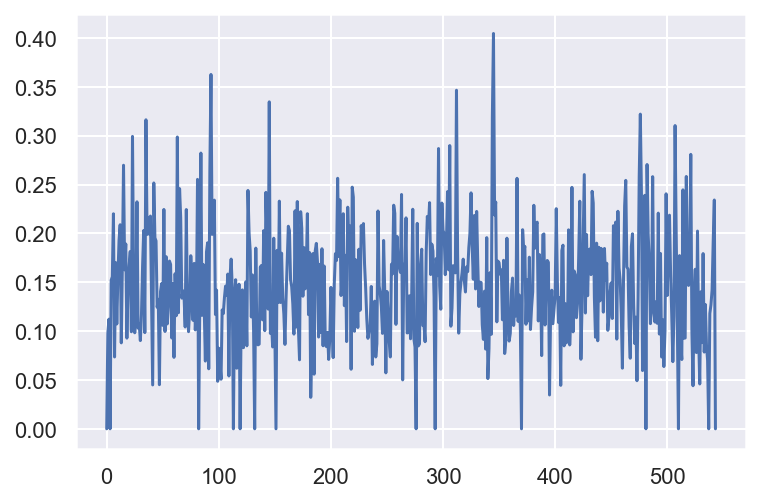

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

plt.plot(dists["ins"])
plt.ion()
plt.show()

In [81]:
count_sample = []
for cnt in count_5mer_sample:
    count_sample += cnt["ins"]

count_control = []
for cnt in count_5mer_control:
    count_control += cnt["ins"]

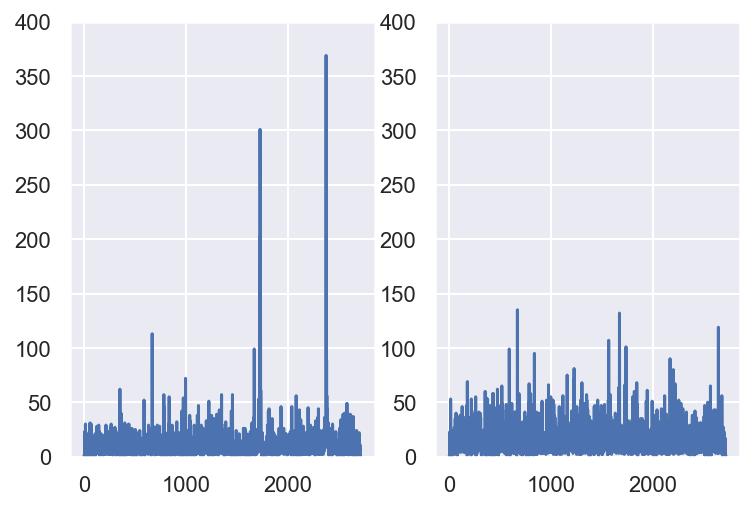

In [87]:
fig = plt.figure()
ax1, ax2 = fig.subplots(1, 2)
ax1.plot(count_sample)
ax2.plot(count_control)
ax1.set_ylim(0, 400)
ax2.set_ylim(0, 400)
plt.ion()
plt.show()

- 無事にInsertionがある箇所だけ、ピークが出ているように思うのですが、なぜかdistsスコアに反映されていないみたいです…？

In [97]:
s = count_5mer_sample[1732//5]["ins"]
c = count_5mer_control[1732//5]["ins"]
print(s, c)
print(distance.jensenshannon(s, c))

[301, 248, 80, 145, 203] [15, 8, 18, 19, 18]
0.21893263280215008


In [98]:
for i, score in enumerate(dists["ins"]):
    if score > 0.4:
        print(i)

345


In [99]:
s = count_5mer_sample[345]["ins"]
c = count_5mer_control[345]["ins"]
print(s, c)
print(distance.jensenshannon(s, c))

[53, 91, 34, 125, 31] [66, 11, 11, 7, 4]
0.40465911011522077


- `Jensen-Shannon距離`だと直感的に反した値になるようです
- 素直にマハラノビス距離を用いたホテリングT2を試してみます

In [125]:
from scipy.stats import chi2

def score_anomaly(count_sample: list[int]) -> list[float]:
    x = np.array(count_sample)
    average = np.mean(x)
    sigma = np.std(x)
    score = ( (x- average)/sigma )**2
    return score.tolist()

def extract_anomaly_loci(score: list[float], threshold: float = 0.99) -> list[int]:
    anomaly_loci = []
    thres = chi2.ppf(q=threshold, df=1)
    for i, s in enumerate(score):
        if s > thres:
            anomaly_loci.append(i)
    return anomaly_loci


Text(0.5, 1.0, 'Anomaly of data')

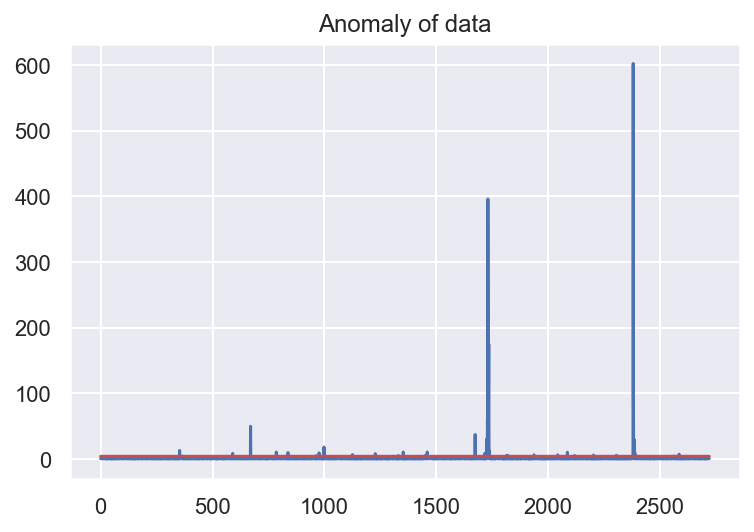

In [358]:
#3.841458820694124
a = score_anomaly(count_sample)
a_th = chi2.ppf(q=0.95, df=1)
plt.plot(a)
plt.plot(a_th*np.ones(len(a)), c="r")
plt.title("Anomaly of data")

In [428]:
count_sample[1730:1735]

[301, 248, 80, 145, 203]

Text(0.5, 1.0, 'Anomaly of data')

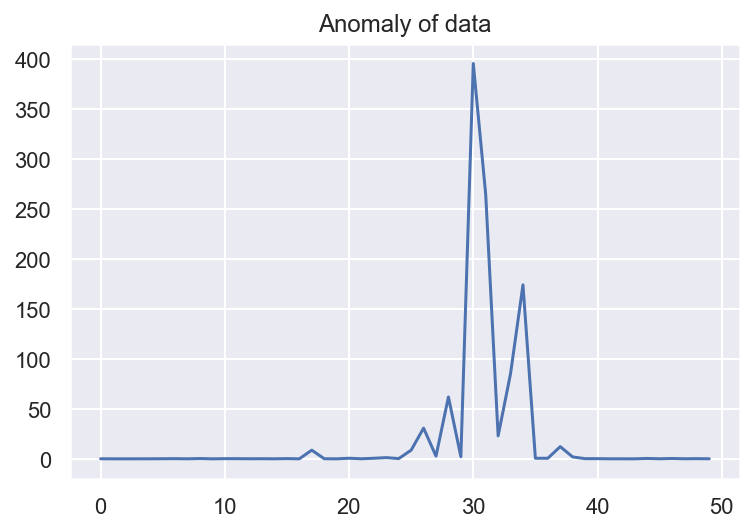

- ホテリングを中心としたシンプルな実装で問題なさそうです…？
- なんで5merにしたのでしょうか…
    - **大型欠失のときのコンセンサス配列表示の問題**でした
    - たまにコントロールでもシークエンスエラーによる欠失が見られるので、単独ではなく周辺配列を見ることでコントロールにおけるシークエンスエラーではないことを言おうとしていたのでした
    - では、5merは維持しつつ、
        - 単独の塩基が異常で、かつ
        - その周辺配列を考慮しても異常
    - という条件にすれば良い気がしてきました


`まず各塩基に対して異常なMIDSを呈している塩基を抽出`  
`つぎにその塩基の周辺配列を比較`
- とすると計算量も下げられる気がします

### まず各塩基に対して異常なMIDSを呈している塩基を抽出

In [163]:
allele = "control"
sequence = FASTA_ALLELES[allele]

midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]


In [165]:
def count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
    count = {"ins": [1] * len(cssplits[0]),
            "del": [1] * len(cssplits[0]),
            "sub": [1] * len(cssplits[0])}
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                count["ins"][i] += 1
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count

In [166]:
from scipy.stats import chi2

def score_anomaly(count_sample: list[int]) -> list[float]:
    x = np.array(count_sample)
    average = np.mean(x)
    sigma = np.std(x)
    score = np.square((x - average) / sigma)
    return score.tolist()

def extract_anomaly_loci(score: list[float], threshold: float = 0.99) -> set[int]:
    anomaly_loci = set()
    thres = chi2.ppf(q=threshold, df=1)
    for i, s in enumerate(score):
        if s > thres:
            anomaly_loci.add(i)
    return anomaly_loci


In [240]:
indels_sample = count_indels(cssplits_sample)
indels_control = count_indels(cssplits_control)

ANOMALY_LOCI = {}
for key in ["ins", "del", "sub"]:
    score_sample = score_anomaly(indels_sample[key])
    loci_sample = extract_anomaly_loci(score_sample)
    score_control = score_anomaly(indels_control[key])
    loci_control = extract_anomaly_loci(score_control)
    ANOMALY_LOCI.update({key: loci_sample - loci_control})

print(len(ANOMALY_LOCI["ins"]))
print(len(ANOMALY_LOCI["del"]))
print(len(ANOMALY_LOCI["sub"]))
print(ANOMALY_LOCI["ins"])

14
6
21
{1728, 1730, 1732, 1733, 1734, 2087, 1735, 1736, 2381, 2382, 2386, 2388, 1719, 2586}


### つぎに、異常塩基の周辺X塩基をコントロールと比較する
- ホモポリマーの場合は周辺配列の一部にピークがある
```
samp = [100,80,90,100,80,90,90,85,75,80] # 大型欠失
cont = [1,1,50,100,80,58,20,2,1,1]       # ホモポリマーによる見た目上の欠失
```

In [234]:
from scipy.spatial import distance
samp = [100,80,90,100,80,90,90,85,75,80] # 大型欠失
cont = [1,1,50,100,80,58,20,2,1,1]       # ホモポリマーによる見た目上の欠失

print(distance.euclidean(samp, cont))

205.35822359964064


In [235]:
samp = [100, 100, 100]
cont = [1, 1, 1]
print(distance.euclidean(samp, cont))

171.47302994931886


In [361]:
samp = [100, 100, 100]
cont = [110, 110, 110]
print(distance.euclidean(samp, cont))

17.320508075688775


In [362]:
def split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def normalize_coverage(indels: dict[str, list[list[int]]], coverage: int):
    results = defaultdict(list)
    for mut, value in indels.items():
        for val in value:
            val_normalized = [v / coverage for v in val]
            results[mut].append(val_normalized)
    return results


In [363]:
x = split_kmer(indels_sample, kmer = 10)
y = split_kmer(indels_control, kmer = 10)
# x = normalize_coverage(x, len(cssplits_sample))
# y = normalize_coverage(y, len(cssplits_control))

In [364]:
print(x["ins"][1732])
print(y["ins"][1732])
print(len(x["ins"]))
print(len(y["ins"]))
xx = x["ins"][1732]
yy = y["ins"][1732]
dist = distance.cosine(xx, yy)
_, pvalue = stats.ttest_ind(xx, yy, equal_var=False)
print(dist, pvalue)

[53, 91, 34, 125, 31, 301, 248, 80, 145, 203]
[66, 11, 11, 7, 4, 15, 8, 18, 19, 18]
2724
2724
0.47576678896864755 0.0037668397375148193


In [365]:
def calc_distance(indels_sample: dict[str, list[list[int]]], indels_control: dict[str, list[list[int]]]) -> dict[str, list[float]]:
    results = defaultdict(list)
    for mut, value in indels_sample.items():
        for i, val in enumerate(value):
            dist = distance.euclidean(val, indels_control[mut][i])
            results[mut].append(dist)
    return results

In [366]:
dists = calc_distance(x, y)

In [367]:
print(len(dists["ins"]))
print(dists["ins"][1000])
print(dists["ins"][1732])

2724
21.330729007701542
463.7801203156513


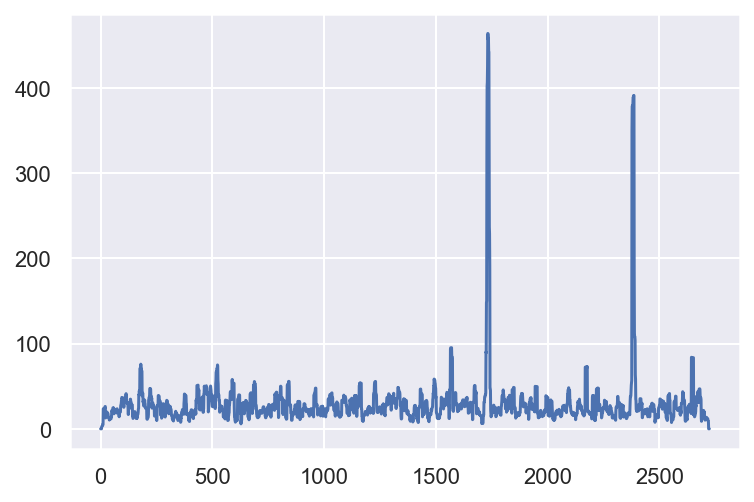

In [368]:
plt.plot(dists["ins"])
plt.show()

In [369]:
x = score_anomaly(dists["ins"])
x_loci = extract_anomaly_loci(x)
# print(x_loci)
print(ANOMALY_LOCI["ins"] & x_loci)

{1728, 1730, 1732, 1733, 1734, 1735, 1736, 2381, 2382, 2386}


In [343]:
from scipy.spatial import distance
from scipy.stats import chi2
# 分散共分散行列の逆行列を計算
cov_i = np.linalg.pinv(cov2)
# 異常度を計算 (マハラノビス距離の2乗値を計算)
anomaly_scores = np.array([x for x in X if distance.mahalanobis(x, mu, cov_i)**2])

In [372]:
from __future__ import annotations
import numpy as np
from collections import defaultdict
from pathlib import Path
from scipy.stats import chi2
from scipy.spatial import distance

import midsv


def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int | float]]:
    count = {"ins": [1] * len(cssplits[0]),
            "del": [1] * len(cssplits[0]),
            "sub": [1] * len(cssplits[0])}
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                count["ins"][i] += 1
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count


def score_anomaly(count_sample: list[int | float]) -> list[float]:
    x = np.array(count_sample)
    average = np.mean(x)
    sigma = np.std(x)
    score = np.square((x - average) / sigma)
    return score.tolist()


def _extract_anomaly_loci(score: list[float], threshold: float = 0.99) -> set[int]:
    anomaly_loci = set()
    thres = chi2.ppf(q=threshold, df=1)
    for i, s in enumerate(score):
        if s > thres:
            anomaly_loci.add(i)
    return anomaly_loci


def _split_kmer(indels: dict[str, list[int | float]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _calc_distance(indels_sample: dict[str, list[list[int]]], indels_control: dict[str, list[list[int]]]) -> dict[str, list[float]]:
    results = defaultdict(list)
    for mut, value in indels_sample.items():
        for i, val in enumerate(value):
            dist = distance.euclidean(val, indels_control[mut][i])
            results[mut].append(dist)
    return results

def _extract(cssplits_sample, cssplits_control) -> dict(set):
    indels_sample = _count_indels(cssplits_sample)
    indels_control = _count_indels(cssplits_control)
    # anomaly at single locus
    mutation_locus_single = {}
    for key in ["ins", "del", "sub"]:
        score_sample = score_anomaly(indels_sample[key])
        loci_sample = _extract_anomaly_loci(score_sample)
        score_control = score_anomaly(indels_control[key])
        loci_control = _extract_anomaly_loci(score_control)
        mutation_locus_single.update({key: loci_sample - loci_control})
    # Difference of anomaly within kmers
    x = _split_kmer(indels_sample, kmer = 10)
    y = _split_kmer(indels_control, kmer = 10)
    dists = _calc_distance(x, y)
    mutation_locus_kmer = {}
    for key in ["ins", "del", "sub"]:
        score_sample = score_anomaly(dists[key])
        loci_sample = _extract_anomaly_loci(score_sample)
        mutation_locus_kmer.update({key: loci_sample})
    # Output
    results = {}
    for key in ["ins", "del", "sub"]:
        results.update({key: mutation_locus_single[key] & mutation_locus_kmer[key]})
    return results



def extract_mutation_loci(TEMPDIR: Path, FASTA_ALLELES: dict, SAMPLE_NAME: str, CONTROL_NAME: str) -> defaultdict(dict(set)):
    mutation_loci = defaultdict(dict)
    for allele in FASTA_ALLELES.keys():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        mutation_loci[allele] = _extract(cssplits_sample, cssplits_control)
    return mutation_loci


In [373]:
allele = "control"
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
x = _extract(cssplits_sample, cssplits_control)


In [374]:
print(x)

{'ins': {1728, 1730, 1732, 1733, 1734, 1735, 1736, 2381, 2382, 2386}, 'del': {394}, 'sub': {2399}}


In [385]:

def _replace_errors_to_atmark(cssplits_sample: list[list[str]], mutation_loci: dict[str, set[int]]) -> list[list[str]]:
    results = []
    for cssplits in cssplits_sample:
        cssplits_replaced = []
        for i, cs in enumerate(cssplits):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                cssplits_replaced.append(cs)
                continue
            if cs.startswith("+"):
                tag = "ins"
            elif cs.startswith("-"):
                tag = "del"
            else:
                tag = "sub"
            if i in mutation_loci[tag]:
                cssplits_replaced.append(cs)
            else:
                cssplits_replaced.append("@")
        results.append(cssplits_replaced)
    return results


In [387]:
cssplits_sample = [["=C", "+C","=C"], ["=C", "-C","=C"]]
mutation_loci = {"ins": {1}, "del": {0}, "sub": {0}}
_replace_errors_to_atmark(cssplits_sample, mutation_loci)

[['=C', '+C', '=C'], ['=C', '@', '=C']]

In [388]:
from __future__ import annotations

import random
import re
from collections import Counter, defaultdict
from pathlib import Path

import midsv
import numpy as np
from scipy import stats
from scipy.spatial import distance


def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
    count = {"ins": [1] * len(cssplits[0]),
            "del": [1] * len(cssplits[0]),
            "sub": [1] * len(cssplits[0])}
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                count["ins"][i] += 1
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count

def _remove_minor_indels(count_indels: dict[str, list[int]], coverage: int) -> dict[str, list[int]]:
    count_indels_removed = dict()
    threshold = coverage * 0.01
    for key, values in count_indels.items():
        values_removed = [v if v >= threshold else 1 for v in values]
        count_indels_removed.update({key: values_removed})
    return count_indels_removed


def _score_anomaly(count_sample: list[int | float]) -> list[float]:
    x = np.array(count_sample)
    average = np.mean(x)
    sigma = np.std(x)
    score = np.square((x - average) / sigma)
    return score.tolist()


def _extract_anomaly_loci(score: list[float], threshold: float = 0.99) -> set[int]:
    anomaly_loci = set()
    thres = chi2.ppf(q=threshold, df=1)
    for i, s in enumerate(score):
        if s > thres:
            anomaly_loci.add(i)
    return anomaly_loci


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _calc_distance(indels_sample: dict[str, list[list[int]]], indels_control: dict[str, list[list[int]]]) -> dict[str, list[float]]:
    results = defaultdict(list)
    for mut, value in indels_sample.items():
        for i, val in enumerate(value):
            dist = distance.euclidean(val, indels_control[mut][i])
            results[mut].append(dist)
    return results

def _extract(cssplits_sample, cssplits_control) -> dict[str, set[int]]:
    indels_sample = _count_indels(cssplits_sample)
    indels_control = _count_indels(cssplits_control)
    indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
    indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
    # anomaly at single locus
    mutation_locus_single = {}
    for key in ["ins", "del", "sub"]:
        score_sample = _score_anomaly(indels_sample[key])
        loci_sample = _extract_anomaly_loci(score_sample)
        score_control = _score_anomaly(indels_control[key])
        loci_control = _extract_anomaly_loci(score_control)
        mutation_locus_single.update({key: loci_sample - loci_control})
    # Difference of anomaly within kmers
    x = _split_kmer(indels_sample, kmer = 10)
    y = _split_kmer(indels_control, kmer = 10)
    dists = _calc_distance(x, y)
    mutation_locus_kmer = {}
    for key in ["ins", "del", "sub"]:
        score_sample = _score_anomaly(dists[key])
        loci_sample = _extract_anomaly_loci(score_sample)
        mutation_locus_kmer.update({key: loci_sample})
    # Output
    results = {}
    for key in ["ins", "del", "sub"]:
        results.update({key: mutation_locus_single[key] & mutation_locus_kmer[key]})
    return results

###########################################################
# postprocesss
###########################################################


def _replace_errors_to_atmark(cssplits_sample: list[list[str]], mutation_loci: dict[str, set[int]]) -> list[list[str]]:
    results = []
    for cssplits in cssplits_sample:
        cssplits_replaced = []
        for i, cs in enumerate(cssplits):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                cssplits_replaced.append(cs)
                continue
            if cs.startswith("+"):
                tag = "ins"
            elif cs.startswith("-"):
                tag = "del"
            else:
                tag = "sub"
            if i in mutation_loci[tag]:
                cssplits_replaced.append(cs)
            else:
                cssplits_replaced.append("@")
        results.append(cssplits_replaced)
    return results


def _replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
    random.seed(1)
    cssplits_replaced = cssplits.copy()
    sequence_length = len(sequence)
    for i in range(1, sequence_length - 1):
        cssplits_atmark = defaultdict(str)
        cssplits_sampling_key = defaultdict(list)
        cssplits_sampling_all = []
        flag_all_atmark = True
        for idx, cssplit in enumerate(cssplits):
            key = ",".join([cssplit[i - 1], cssplit[i + 1]])
            if cssplit[i] == "@":
                cssplits_atmark[idx] = key
            else:
                cssplits_sampling_key[key].append(cssplit[i])
                cssplits_sampling_all.append(cssplit[i])
                flag_all_atmark = False
        for idx, key in cssplits_atmark.items():
            if flag_all_atmark:
                cssplits_replaced[idx][i] = "N"
            elif cssplits_sampling_key[key]:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
            else:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
    for cs in cssplits_replaced:
        if cs[0] == "@":
            cs[0] = "N"
        if cs[-1] == "@":
            cs[-1] = "N"
    return cssplits_replaced

###############################################################################
# main
###############################################################################


def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        # Extract mutation loci
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        mutation_loci = _extract(cssplits_sample, cssplits_control)
        # Correct sequence errors
        cssplits_sample_atmark = _replace_errors_to_atmark(cssplits_sample, mutation_loci)
        cssplits_control_atmark = _replace_errors_to_atmark(cssplits_control, mutation_loci)
        cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_atmark, sequence)
        cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_atmark, sequence)
        # Replace CSSPLIT
        cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
        cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
        for i, cssplits in enumerate(cssplits_sample_corrected):
            midsv_sample[i]["CSSPLIT"] = cssplits
        for i, cssplits in enumerate(cssplits_control_corrected):
            midsv_control[i]["CSSPLIT"] = cssplits
        midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl"))
        midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl"))

In [389]:
allele = "control"

In [390]:
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Extract mutation loci
mutation_loci = _extract(cssplits_sample, cssplits_control)
# Correct sequence errors
cssplits_sample_atmark = _replace_errors_to_atmark(cssplits_sample, mutation_loci)
cssplits_control_atmark = _replace_errors_to_atmark(cssplits_control, mutation_loci)
cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_atmark, sequence)
cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_atmark, sequence)
# Replace CSSPLIT
cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]


In [392]:
for idx, loxp in idx_loxps.items():
    for i,cs in enumerate(cssplits_sample_atmark_replaced[idx]):
        if cs.startswith("+"):
            print(loxp, i, cs)

idx_right_loxp 1732 +T|+T|+C|+C|+A|+A|+C|+A|+T|+A|+A|+C|+T|+G|+C|+A|+T|+A|+T|+A|+C|+A|+T|+T|+A|+T|+A|+A|+T|+G|+A|+A|+G|+T|+T|+A|+T|+G|+G|+C|+G|+C|+G|+C|=C
idx_left_loxp 2381 +C|+G|+C|+G|+C|+C|+A|+A|+T|+T|+C|+G|+A|+T|+A|+T|+C|+A|+A|+G|+C|+T|+A|+T|+A|+A|+C|+T|+G|+G|+T|+A|+T|+A|+G|+C|+A|+T|+A|+C|+A|+T|+T|+A|+T|+A|+C|+G|+A|+A|+G|+T|+T|+A|+T|+G|+C|+G|+G|+C|+C|=C
idx_both_loxp 2381 +C|+G|+C|+C|+A|+A|+T|+T|+C|+G|+A|+T|+A|+T|+C|+A|+A|+G|+C|+T|+A|+T|+A|+A|+C|+T|+T|+C|+G|+T|+A|+T|+A|+G|+C|+A|+T|+A|+C|+A|+T|+G|+A|+G|+T|+A|+C|+G|+A|+A|+G|+C|+T|+A|+T|+G|+C|+G|+G|+C|+C|=C


In [408]:
print(mutation_loci["ins"])

{1728, 1730, 1732, 1733, 1734, 1735, 1736, 2381, 2382, 2386}


- なぜか1731がない！
- ただ結局のところ、insertionのみのアレルを作るのでここではあまり気にしなくて良いかも？

In [425]:
indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
indels_control = _remove_minor_indels(indels_control, len(cssplits_control))

In [426]:
print(indels_sample["ins"][1730:1735])
print(indels_sample["ins"][1000:1005])
print(indels_sample["ins"][1731])
print(indels_control["ins"][1731])

[125, 31, 301, 248, 80]
[72, 15, 10, 1, 20]
31
1


In [421]:
mutation_locus_single = {}
for key in ["ins", "del", "sub"]:
    score_sample = _score_anomaly(indels_sample[key])
    loci_sample = _extract_anomaly_loci(score_sample)
    score_control = _score_anomaly(indels_control[key])
    loci_control = _extract_anomaly_loci(score_control)
    mutation_locus_single.update({key: loci_sample - loci_control})
print(mutation_locus_single["ins"])
print(loci_sample & {1731})


{1728, 1730, 1732, 1733, 1734, 2087, 1735, 1736, 2381, 2382, 2386, 2388, 1719, 2586}
set()


In [427]:
key = "ins"
score_sample = _score_anomaly(indels_sample[key])
loci_sample = _extract_anomaly_loci(score_sample)
score_control = _score_anomaly(indels_control[key])
loci_control = _extract_anomaly_loci(score_control)
mutation_locus_single.update({key: loci_sample - loci_control})
print(score_sample[1730:1735])
thres = chi2.ppf(q=0.99, df=1)
print(thres)

[58.39085195185807, 2.3195356573695993, 364.69910914856547, 244.84009962569107, 22.206477443088954]
6.6348966010212145


In [ ]:
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]

In [437]:
count = defaultdict(int)
for cssplits in cssplits_sample:
    cs = cssplits[1731]
    if cs.startswith("+"):
        count["ins"] += 1

print(count)

defaultdict(<class 'int'>, {'ins': 30})


In [446]:
def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
    count = {"ins": [1] * len(cssplits[0]),
            "del": [1] * len(cssplits[0]),
            "sub": [1] * len(cssplits[0])}
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                count["ins"][i] += len(cs.split("|"))
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count


In [447]:
x = _count_indels(cssplits_sample)
print(x["ins"][1731])

606


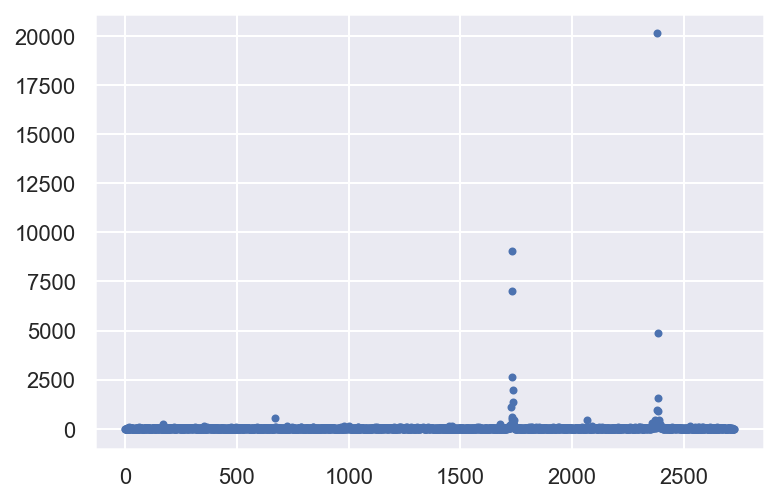

In [448]:
plt.plot(x["ins"], ".")
plt.show()

In [450]:
indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
key = "ins"
score_sample = _score_anomaly(indels_sample[key])
loci_sample = _extract_anomaly_loci(score_sample)
score_control = _score_anomaly(indels_control[key])
loci_control = _extract_anomaly_loci(score_control)
mutation_locus_single.update({key: loci_sample - loci_control})
print(score_sample[1730:1735])
thres = chi2.ppf(q=0.99, df=1)
print(thres)

[31.24201308791873, 1.4809880638749122, 383.0931697633896, 228.02359731115035, 0.36082367115621583]
6.6348966010212145


In [461]:
count = 0
for score in score_sample:
    if score > 1.4:
        count += 1

print(count)

12


In [466]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor()
key = "ins"
x = indels_sample[key]
pred = clf.fit_predict(np.array(x).reshape(-1, 1))

In [468]:
print(Counter(pred))
print(pred[1730:1735])

Counter({1: 2642, -1: 82})
[-1 -1 -1 -1  1]


In [469]:
def _extract_anomaly_loci(count_indels: dict[str, list[int]]) -> dict[set[int]]:
    anomaly_loci = dict()
    clf = LocalOutlierFactor()
    for key, values in count_indels.items():
        pred = clf.fit_predict(np.array(values).reshape(-1, 1))
        loci = {i for i, p in enumerate(pred) if p == -1}
        anomaly_loci.update({key: loci})
    return anomaly_loci



In [476]:
x = _extract_anomaly_loci(indels_sample)
y = _extract_anomaly_loci(indels_control)
print((x["ins"] - y["ins"]) & {1731})

{1731}


In [481]:
def _extract(cssplits_sample, cssplits_control) -> dict[str, set[int]]:
    indels_sample = _count_indels(cssplits_sample)
    indels_control = _count_indels(cssplits_control)
    indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
    indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
    # anomaly at single locus
    mutation_locus_single = {}
    # score_sample = _score_anomaly(indels_sample[key])
    loci_sample = _extract_anomaly_loci(indels_sample)
    # score_control = _score_anomaly(indels_control[key])
    loci_control = _extract_anomaly_loci(indels_control)
    for key in ["ins", "del", "sub"]:
        mutation_locus_single.update({key: loci_sample[key] & loci_control[key]})
    # Difference of anomaly within kmers
    x = _split_kmer(indels_sample, kmer = 10)
    y = _split_kmer(indels_control, kmer = 10)
    dists = _calc_distance(x, y)
    loci_sample = _extract_anomaly_loci(dists)
    mutation_locus_kmer = {}
    for key in ["ins", "del", "sub"]:
        # score_sample = _score_anomaly(dists[key])
        mutation_locus_kmer.update({key: loci_sample[key]})
    # Output
    results = {}
    for key in ["ins", "del", "sub"]:
        results.update({key: mutation_locus_single[key] & mutation_locus_kmer[key]})
    return results

In [482]:
x = _extract(cssplits_sample, cssplits_control)

In [483]:
print(x["ins"])

{1739}


In [499]:
indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
# anomaly at single locus
mutation_locus_single = {}
loci_sample = _extract_anomaly_loci(indels_sample)
loci_control = _extract_anomaly_loci(indels_control)
for key in ["ins", "del", "sub"]:
    mutation_locus_single.update({key: loci_sample[key] - loci_control[key]})
# Difference of anomaly within kmers
x = _split_kmer(indels_sample, kmer = 10)
y = _split_kmer(indels_control, kmer = 10)
dists = _calc_distance(x, y)
loci_sample = _extract_anomaly_loci(dists)
mutation_locus_kmer = {}
for key in ["ins", "del", "sub"]:
    # score_sample = _score_anomaly(dists[key])
    mutation_locus_kmer.update({key: loci_sample[key]})
# Output
results = {}
for key in ["ins", "del", "sub"]:
    results.update({key: mutation_locus_single[key] & mutation_locus_kmer[key]})


In [500]:
print(len(mutation_locus_kmer["ins"]))

59


In [501]:
print(len(mutation_locus_single["ins"]))

80


In [502]:
print(len(loci_sample["ins"] - loci_control["ins"]))

56


In [504]:
print(len(results["ins"]))
print(results["ins"])

3
{1728, 2372, 2388}


In [511]:
print(dists["ins"][1730:1735])
loci_sample = _extract_anomaly_loci(dists)
print(loci_sample["ins"] & {1731})

[11791.876313801804, 11948.680387390064, 12021.04571158433, 12021.784351750783, 11974.17633910575]
set()


In [516]:
print(x["ins"][1730:1735])
print(x["ins"][1000:1005])
print(dists["ins"][1730:1735])
print(dists["ins"][1000:10005])

[[177, 73, 272, 1103, 502, 2621, 606, 9065, 7004, 322], [73, 272, 1103, 502, 2621, 606, 9065, 7004, 322, 1977], [272, 1103, 502, 2621, 606, 9065, 7004, 322, 1977, 1360], [1103, 502, 2621, 606, 9065, 7004, 322, 1977, 1360, 204], [502, 2621, 606, 9065, 7004, 322, 1977, 1360, 204, 136]]
[[39, 26, 24, 29, 43, 167, 38, 24, 1, 47], [26, 24, 29, 43, 167, 38, 24, 1, 47, 25], [24, 29, 43, 167, 38, 24, 1, 47, 25, 15], [29, 43, 167, 38, 24, 1, 47, 25, 15, 18], [43, 167, 38, 24, 1, 47, 25, 15, 18, 12]]
[11791.876313801804, 11948.680387390064, 12021.04571158433, 12021.784351750783, 11974.17633910575]
[53.376024580330075, 52.773099207835045, 60.40695324215582, 57.41950887982237, 57.445626465380286, 57.619441163551734, 41.47288270665544, 41.52107898405339, 51.419840528729765, 48.620983124572874, 49.28488612140643, 57.91372894228103, 47.853944456021594, 47.75981574503821, 49.457052075512955, 52.28766584960549, 52.29722745997153, 55.27205442174191, 67.57958271549181, 71.14773362518304, 70.6399320497974

90


In [540]:
print(len(pred))
print(pred)
print(loci)
print(np.array(values).shape)
print(np.array(values).reshape(-1, 1).shape)

27240
[1 1 1 ... 1 1 1]
{20481, 20490, 22539, 22548, 22557, 22566, 22575, 22584, 22593, 22602, 22611, 22620, 13919, 13928, 13937, 13946, 13955, 13964, 6799, 13973, 6808, 13982, 6817, 13991, 6826, 14000, 6835, 7859, 7868, 6844, 6853, 7877, 6862, 7886, 7895, 6871, 6880, 7904, 23779, 7913, 23788, 7922, 23797, 7931, 23806, 7940, 23815, 23824, 23833, 23842, 23851, 23860, 17229, 17238, 17247, 17256, 25449, 17259, 17265, 25458, 17268, 17274, 25467, 17277, 17283, 25476, 17286, 17292, 25485, 17295, 17301, 25494, 17304, 17310, 25503, 17313, 25512, 17322, 25521, 17331, 20409, 25530, 17340, 20418, 20427, 20436, 20445, 20454, 20463, 20472}
(2724, 10)
(27240, 1)


In [529]:
def _extract_anomaly_loci(count_indels: dict[str, list[int | float]]) -> dict[str, set[int]]:
    anomaly_loci = dict()
    clf = LocalOutlierFactor()
    for key, values in count_indels.items():
        pred = clf.fit_predict(np.array(values).reshape(-1, 1))
        loci = {i for i, p in enumerate(pred) if p == -1}
        anomaly_loci.update({key: loci})
    return anomaly_loci


In [541]:
indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
# anomaly at single locus
mutation_locus_single = {}
loci_sample = _extract_anomaly_loci(indels_sample)
loci_control = _extract_anomaly_loci(indels_control)
for key in ["ins", "del", "sub"]:
    mutation_locus_single.update({key: loci_sample[key] - loci_control[key]})
# Difference of anomaly within kmers
x = _split_kmer(indels_sample, kmer = 10)
y = _split_kmer(indels_control, kmer = 10)
dists = _calc_distance(x, y)
loci_sample = _extract_anomaly_loci(dists)
mutation_locus_kmer = {}
for key in ["ins", "del", "sub"]:
    # score_sample = _score_anomaly(dists[key])
    mutation_locus_kmer.update({key: loci_sample[key]})
# Output
results = {}
for key in ["ins", "del", "sub"]:
    results.update({key: mutation_locus_single[key] & mutation_locus_kmer[key]})


In [544]:
x = indels_sample["ins"]
print(x)

[1, 1, 1, 1, 1, 1, 1, 1, 11, 53, 1, 31, 32, 20, 10, 1, 84, 1, 11, 10, 12, 1, 28, 24, 28, 1, 23, 25, 26, 38, 12, 20, 22, 1, 36, 1, 14, 11, 14, 15, 17, 10, 1, 13, 1, 25, 1, 1, 1, 13, 48, 29, 38, 44, 15, 1, 1, 33, 11, 1, 13, 72, 12, 1, 1, 27, 1, 33, 21, 68, 27, 19, 1, 64, 19, 1, 1, 10, 16, 15, 14, 10, 1, 24, 44, 27, 1, 1, 25, 15, 1, 20, 1, 39, 18, 27, 19, 16, 14, 30, 18, 28, 22, 15, 13, 19, 27, 12, 34, 28, 1, 53, 13, 14, 15, 1, 1, 13, 1, 30, 12, 25, 1, 46, 12, 39, 23, 39, 1, 67, 1, 38, 1, 16, 10, 49, 50, 18, 16, 35, 16, 21, 21, 20, 12, 1, 12, 57, 11, 18, 31, 23, 15, 60, 35, 36, 1, 18, 17, 36, 23, 16, 41, 1, 22, 12, 1, 17, 10, 16, 249, 61, 1, 13, 11, 36, 18, 1, 10, 19, 27, 15, 15, 23, 12, 23, 46, 1, 17, 51, 14, 1, 31, 29, 35, 16, 1, 1, 24, 11, 34, 31, 15, 24, 1, 20, 1, 33, 49, 40, 50, 27, 24, 18, 22, 12, 1, 1, 69, 56, 50, 21, 17, 1, 29, 16, 1, 21, 15, 11, 21, 18, 17, 40, 38, 41, 34, 20, 31, 1, 49, 30, 26, 29, 1, 30, 40, 1, 29, 1, 1, 1, 21, 41, 42, 28, 1, 33, 13, 1, 23, 11, 55, 1, 1, 14, 25

In [545]:
values = x
pred = clf.fit_predict(np.array(values).reshape(-1, 1))
loci = {i for i, p in enumerate(pred) if p == -1}
print(len(loci))

82


In [550]:
print(loci & {1731})
mutation_locus_kmer["ins"] & {1731}

{1731}


set()

In [566]:
clf = LocalOutlierFactor()
values = dists["ins"]
pred = clf.fit_predict(np.array(values).reshape(-1, 1))
loci = {i for i, p in enumerate(pred) if p == -1}
print(Counter(pred))
print(pred[1730:1735])

Counter({1: 2665, -1: 59})
[1 1 1 1 1]


In [565]:
for val, p in zip(values, pred):
    if p == -1:
        print(val)

0.0
0.0
0.0
0.0
0.0
10.04987562112089
10.04987562112089
14.177446878757825
209.43734146517426
210.8838542895117
203.00246303924493
128.49513609471762
128.50680915811427
13.30413469565007
13.30413469565007
126.87001221722964
126.91335627111907
126.89365626381802
130.6981254647518
206.39040675380238
209.3155512617254
208.88513590009222
209.57337617168838
210.04999404903586
210.90756269038812
298.234806821739
1122.8236727109027
1215.7619010316123
2876.4113057766963
2936.075952696047
9497.727254454088
7380.399718172452
2389.149639516119
2372.4620123407667
1372.7170138087456
312.23708940483033
309.05015774142555
514.576524921221
604.0049668669952
664.6931622937008
676.2351661959026
667.645864212458
682.6822101095062
727.9773348120118
731.3918238536714
804.7713961119642
1228.9076450246373
5239.102594910697
1886.3605169744196
1868.126334057737
1867.2260173851478
1642.387591282886
600.5838825676227
556.3110640639821
128.7944098165755
0.0
0.0
0.0
0.0


In [567]:
from sklearn.ensemble import IsolationForest
values = dists["ins"]
clf = IsolationForest(random_state=0)
pred = clf.fit_predict(np.array(values).reshape(-1, 1))
loci = {i for i, p in enumerate(pred) if p == -1}
print(Counter(pred))
print(pred[1730:1735])

Counter({1: 2492, -1: 232})
[-1 -1 -1 -1 -1]


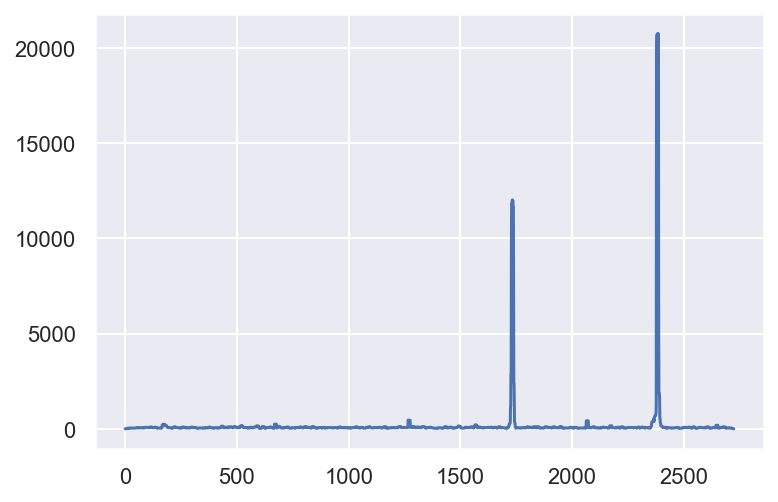

In [564]:
plt.plot(dists["ins"])# [1730:1735]
plt.show()

In [568]:
from __future__ import annotations

import random
import re
from collections import Counter, defaultdict
from pathlib import Path

import midsv
import numpy as np
from scipy.stats import chi2
from scipy.spatial import distance
from sklearn.ensemble import IsolationForest


def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
    count = {"ins": [1] * len(cssplits[0]),
            "del": [1] * len(cssplits[0]),
            "sub": [1] * len(cssplits[0])}
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                count["ins"][i] += len(cs.split("|"))
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count

def _remove_minor_indels(count_indels: dict[str, list[int]], coverage: int) -> dict[str, list[int]]:
    count_indels_removed = dict()
    threshold = coverage * 0.01
    for key, values in count_indels.items():
        values_removed = [v if v >= threshold else 1 for v in values]
        count_indels_removed.update({key: values_removed})
    return count_indels_removed


def _extract_anomaly_loci(count_indels: dict[str, list[int | float]]) -> dict[str, set[int]]:
    anomaly_loci = dict()
    for key, values in count_indels.items():
        clf = IsolationForest(random_state=0)
        pred = clf.fit_predict(np.array(values).reshape(-1, 1))
        loci = {i for i, p in enumerate(pred) if p == -1}
        anomaly_loci.update({key: loci})
    return anomaly_loci

# def _score_anomaly(count_sample: list[int | float]) -> list[float]:
#     x = np.array(count_sample)
#     average = np.mean(x)
#     sigma = np.std(x)
#     score = np.square((x - average) / sigma)
#     return score.tolist()


# def _extract_anomaly_loci(score: list[float], threshold: float = 0.99) -> set[int]:
#     anomaly_loci = set()
#     thres = chi2.ppf(q=threshold, df=1)
#     for i, s in enumerate(score):
#         if s > thres:
#             anomaly_loci.add(i)
#     return anomaly_loci


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _calc_distance(indels_sample: dict[str, list[list[int]]], indels_control: dict[str, list[list[int]]]) -> dict[str, list[float]]:
    results = defaultdict(list)
    for mut, value in indels_sample.items():
        for i, val in enumerate(value):
            dist = distance.euclidean(val, indels_control[mut][i])
            results[mut].append(dist)
    return results

def _extract(cssplits_sample, cssplits_control) -> dict[str, set[int]]:
    indels_sample = _count_indels(cssplits_sample)
    indels_control = _count_indels(cssplits_control)
    indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
    indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
    # anomaly at single locus
    mutation_locus_single = {}
    # score_sample = _score_anomaly(indels_sample[key])
    # score_control = _score_anomaly(indels_control[key])
    loci_sample = _extract_anomaly_loci(indels_sample)
    loci_control = _extract_anomaly_loci(indels_control)
    for key in ["ins", "del", "sub"]:
        mutation_locus_single.update({key: loci_sample[key] - loci_control[key]})
    # Difference of anomaly within kmers
    x = _split_kmer(indels_sample, kmer = 10)
    y = _split_kmer(indels_control, kmer = 10)
    dists = _calc_distance(x, y)
    loci_sample = _extract_anomaly_loci(dists)
    mutation_locus_kmer = {}
    for key in ["ins", "del", "sub"]:
        # score_sample = _score_anomaly(dists[key])
        mutation_locus_kmer.update({key: loci_sample[key]})
    # Output
    results = {}
    for key in ["ins", "del", "sub"]:
        results.update({key: mutation_locus_single[key] & mutation_locus_kmer[key]})
    return results

###########################################################
# postprocesss
###########################################################


def _replace_errors_to_atmark(cssplits_sample: list[list[str]], mutation_loci: dict[str, set[int]]) -> list[list[str]]:
    results = []
    for cssplits in cssplits_sample:
        cssplits_replaced = []
        for i, cs in enumerate(cssplits):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                cssplits_replaced.append(cs)
                continue
            if cs.startswith("+"):
                tag = "ins"
            elif cs.startswith("-"):
                tag = "del"
            else:
                tag = "sub"
            if i in mutation_loci[tag]:
                cssplits_replaced.append(cs)
            else:
                cssplits_replaced.append("@")
        results.append(cssplits_replaced)
    return results


def _replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
    random.seed(1)
    cssplits_replaced = cssplits.copy()
    sequence_length = len(sequence)
    for i in range(1, sequence_length - 1):
        cssplits_atmark = defaultdict(str)
        cssplits_sampling_key = defaultdict(list)
        cssplits_sampling_all = []
        flag_all_atmark = True
        for idx, cssplit in enumerate(cssplits):
            key = ",".join([cssplit[i - 1], cssplit[i + 1]])
            if cssplit[i] == "@":
                cssplits_atmark[idx] = key
            else:
                cssplits_sampling_key[key].append(cssplit[i])
                cssplits_sampling_all.append(cssplit[i])
                flag_all_atmark = False
        for idx, key in cssplits_atmark.items():
            if flag_all_atmark:
                cssplits_replaced[idx][i] = "N"
            elif cssplits_sampling_key[key]:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
            else:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
    for cs in cssplits_replaced:
        if cs[0] == "@":
            cs[0] = "N"
        if cs[-1] == "@":
            cs[-1] = "N"
    return cssplits_replaced

###############################################################################
# main
###############################################################################


def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        # Extract mutation loci
        mutation_loci = _extract(cssplits_sample, cssplits_control)
        # Correct sequence errors
        cssplits_sample_atmark = _replace_errors_to_atmark(cssplits_sample, mutation_loci)
        cssplits_control_atmark = _replace_errors_to_atmark(cssplits_control, mutation_loci)
        cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_atmark, sequence)
        cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_atmark, sequence)
        # Replace CSSPLIT
        cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
        cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
        for i, cssplits in enumerate(cssplits_sample_corrected):
            midsv_sample[i]["CSSPLIT"] = cssplits
        for i, cssplits in enumerate(cssplits_control_corrected):
            midsv_control[i]["CSSPLIT"] = cssplits
        midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl"))
        midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl"))


# def _set_indexes(sequence: str):
#     sequence_length = len(sequence)
#     num_subset = sequence_length % 5
#     left_idx = 0
#     right_idx = sequence_length
#     if num_subset == 1:
#         left_idx += 1
#     elif num_subset == 2:
#         left_idx += 1
#         right_idx -= 1
#     elif num_subset == 3:
#         left_idx += 2
#         right_idx -= 1
#     elif num_subset == 4:
#         left_idx += 2
#         right_idx -= 2
#     return left_idx, right_idx


# def _count_5mer_indels(cssplits: list[list[str]], left_idx: int, right_idx: int) -> list[dict]:
#     transposed = [list(t) for t in zip(*cssplits)]
#     count_5mer = []
#     for i in range(left_idx, right_idx, 5):
#         count = {"ins": [1] * 5, "del": [1] * 5, "sub": [1] * 5}
#         cssplits_5mer = transposed[i : i + 5]
#         for j, cs in enumerate(cssplits_5mer):
#             counter = Counter(cs)
#             for key, cnt in counter.items():
#                 if key.startswith("=") or key == "N" or re.search(r"a|c|g|t|n", key):
#                     continue
#                 if key.startswith("+"):
#                     count["ins"][j] += cnt
#                 elif key.startswith("-"):
#                     count["del"][j] += cnt
#                 elif key.startswith("*"):
#                     count["sub"][j] += cnt
#         count_5mer.append(count)
#     return count_5mer


# def _remove_minor_indels(cssplits: list[list[str]], count_5mer: list[dict]) -> list[dict]:
#     coverage = len(cssplits)
#     count_5mer_filtered = []
#     for count in count_5mer:
#         dict_mutation = defaultdict(list)
#         for mutation in ["ins", "del", "sub"]:
#             if all(True if c < coverage * 0.01 else False for c in count[mutation]):
#                 dict_mutation[mutation] = [1] * 5
#             else:
#                 dict_mutation[mutation] = count[mutation]
#         count_5mer_filtered.append(dict_mutation)
#     return count_5mer_filtered


# def _extract_sequence_errors(count_5mer_sample, count_5mer_control):
#     sequence_errors = [set() for _ in range(len(count_5mer_sample))]
#     dists = defaultdict(list)
#     # Calculate Jensen-Shannon distance
#     for samp, cont in zip(count_5mer_sample, count_5mer_control):
#         for mutation in ["ins", "del", "sub"]:
#             s = samp[mutation]
#             c = cont[mutation]
#             dists[mutation].append(distance.jensenshannon(s, c))
#     # Discrimitate seq errors and real mutation using Hotelling's T-squared distribution
#     dists_all = np.array(list(dists.values())).flatten()
#     avg = np.average(dists_all[~np.isnan(dists_all)])
#     var = np.var(dists_all[~np.isnan(dists_all)])
#     threshold = 0.05
#     for mutation in ["ins", "del", "sub"]:
#         dists_subset = dists[mutation]
#         scores = [(xi - avg) ** 2 / var for xi in dists_subset]
#         thres = stats.chi2.interval(1 - threshold, 1)[1]
#         for i, score in enumerate(scores):
#             # 'nan' means the two distributions have too different, so it could be a real mutation
#             if np.isnan(score):
#                 continue
#             if score < thres:
#                 sequence_errors[i].add(mutation)
#     return sequence_errors


# def _replace_errors_to_atmark(cssplits_sample, sequence_errors, left_idx, right_idx):
#     cssplits_replaced = []
#     for samp in cssplits_sample:
#         samp_replaced = samp.copy()
#         for idx_error, idx_5mer in enumerate(range(left_idx, right_idx, 5)):
#             samp_5mer = samp[idx_5mer : idx_5mer + 5]
#             error = sequence_errors[idx_error]
#             if "ins" in error:
#                 samp_5mer = ["@" if cs.startswith("+") else cs for cs in samp_5mer]
#             if "del" in error:
#                 samp_5mer = ["@" if cs.startswith("-") else cs for cs in samp_5mer]
#             if "sub" in error:
#                 samp_5mer = ["@" if cs.startswith("*") else cs for cs in samp_5mer]
#             samp_replaced[idx_5mer : idx_5mer + 5] = samp_5mer
#         cssplits_replaced.append(samp_replaced)
#     return cssplits_replaced


# def _replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
#     random.seed(1)
#     cssplits_replaced = cssplits.copy()
#     sequence_length = len(sequence)
#     for i in range(1, sequence_length - 1):
#         cssplits_atmark = defaultdict(str)
#         cssplits_sampling_key = defaultdict(list)
#         cssplits_sampling_all = []
#         flag_all_atmark = True
#         for idx, cssplit in enumerate(cssplits):
#             key = ",".join([cssplit[i - 1], cssplit[i + 1]])
#             if cssplit[i] == "@":
#                 cssplits_atmark[idx] = key
#             else:
#                 cssplits_sampling_key[key].append(cssplit[i])
#                 cssplits_sampling_all.append(cssplit[i])
#                 flag_all_atmark = False
#         for idx, key in cssplits_atmark.items():
#             if flag_all_atmark:
#                 cssplits_replaced[idx][i] = "N"
#             elif cssplits_sampling_key[key]:
#                 cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
#             else:
#                 cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
#     for cs in cssplits_replaced:
#         if cs[0] == "@":
#             cs[0] = "N"
#         if cs[-1] == "@":
#             cs[-1] = "N"
#     return cssplits_replaced


# ###############################################################################
# # main
# ###############################################################################


# def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
#     for allele, sequence in FASTA_ALLELES.items():
#         midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
#         midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
#         cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
#         cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
#         # Extract sequence errors
#         left_idx, right_idx = _set_indexes(sequence)
#         count_5mer_sample = _count_5mer_indels(cssplits_sample, left_idx, right_idx)
#         count_5mer_control = _count_5mer_indels(cssplits_control, left_idx, right_idx)
#         count_5mer_sample = _remove_minor_indels(cssplits_sample, count_5mer_sample)
#         count_5mer_control = _remove_minor_indels(cssplits_control, count_5mer_control)
#         sequence_errors = _extract_sequence_errors(count_5mer_sample, count_5mer_control)
#         # Correct sequence errors
#         cssplits_sample_error_replaced = _replace_errors_to_atmark(cssplits_sample, sequence_errors, left_idx, right_idx)
#         cssplits_control_error_replaced = _replace_errors_to_atmark(
#             cssplits_control, sequence_errors, left_idx, right_idx
#         )
#         cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_error_replaced, sequence)
#         cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_error_replaced, sequence)
#         # Replace CSSPLIT
#         cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
#         cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
#         for i, cssplits in enumerate(cssplits_sample_corrected):
#             midsv_sample[i]["CSSPLIT"] = cssplits
#         for i, cssplits in enumerate(cssplits_control_corrected):
#             midsv_control[i]["CSSPLIT"] = cssplits
#         midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl"))
#         midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl"))


In [569]:
indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
# anomaly at single locus
mutation_locus_single = {}
# score_sample = _score_anomaly(indels_sample[key])
# score_control = _score_anomaly(indels_control[key])
loci_sample = _extract_anomaly_loci(indels_sample)
loci_control = _extract_anomaly_loci(indels_control)
for key in ["ins", "del", "sub"]:
    mutation_locus_single.update({key: loci_sample[key] - loci_control[key]})
# Difference of anomaly within kmers
x = _split_kmer(indels_sample, kmer = 10)
y = _split_kmer(indels_control, kmer = 10)
dists = _calc_distance(x, y)
loci_sample = _extract_anomaly_loci(dists)
mutation_locus_kmer = {}
for key in ["ins", "del", "sub"]:
    # score_sample = _score_anomaly(dists[key])
    mutation_locus_kmer.update({key: loci_sample[key]})
# Output
results = {}
for key in ["ins", "del", "sub"]:
    results.update({key: mutation_locus_single[key] & mutation_locus_kmer[key]})


In [572]:
results["ins"] & {1731}

{1731}

- 確認

In [573]:
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_splice_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_splice_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Extract mutation loci
mutation_loci = _extract(cssplits_sample, cssplits_control)
# Correct sequence errors
cssplits_sample_atmark = _replace_errors_to_atmark(cssplits_sample, mutation_loci)
cssplits_control_atmark = _replace_errors_to_atmark(cssplits_control, mutation_loci)
cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_atmark, sequence)
cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_atmark, sequence)


In [574]:
for idx, loxp in idx_loxps.items():
    for i,cs in enumerate(cssplits_sample_atmark_replaced[idx]):
        if cs.startswith("+"):
            print(loxp, i, cs)

idx_right_loxp 1732 +T|+T|+C|+C|+A|+A|+C|+A|+T|+A|+A|+C|+T|+G|+C|+A|+T|+A|+T|+A|+C|+A|+T|+T|+A|+T|+A|+A|+T|+G|+A|+A|+G|+T|+T|+A|+T|+G|+G|+C|+G|+C|+G|+C|=C
idx_right_loxp 2396 +T|*CG
idx_no_loxp 1732 +T|+A|+T|+G|+G|+C|+G|+C|+G|+C|=C
idx_left_loxp 2381 +C|+G|+C|+G|+C|+C|+A|+A|+T|+T|+C|+G|+A|+T|+A|+T|+C|+A|+A|+G|+C|+T|+A|+T|+A|+A|+C|+T|+G|+G|+T|+A|+T|+A|+G|+C|+A|+T|+A|+C|+A|+T|+T|+A|+T|+A|+C|+G|+A|+A|+G|+T|+T|+A|+T|+G|+C|+G|+G|+C|+C|=C
idx_both_loxp 1731 +T|+C|+A|+A|+A|+C|+A|+T|+A|+A|+C|+T|+T|+C|+G|+T|+A|+T|+A|+G|+C|+A|+T|+A|+C|+A|+T|+T|+A|+T|+A|+C|+G|+A|+A|+G|+T|+T|+A|+T|+G|+G|+C|+G|+C|+G|+C|+C|=T
idx_both_loxp 2381 +C|+G|+C|+C|+A|+A|+T|+T|+C|+G|+A|+T|+A|+T|+C|+A|+A|+G|+C|+T|+A|+T|+A|+A|+C|+T|+T|+C|+G|+T|+A|+T|+A|+G|+C|+A|+T|+A|+C|+A|+T|+G|+A|+G|+T|+A|+C|+G|+A|+A|+G|+C|+T|+A|+T|+G|+C|+G|+G|+C|+C|=C


In [576]:
samp = midsv_sample[idx_no_loxp]
print(samp["CSSPLIT"].split(",")[1732])

-C


- 存在しない挿入塩基を付与してしまっています
    - `idx_no_loxp 1732 +T|+A|+T|+G|+G|+C|+G|+C|+G|+C|=C`
- これは`N`に置き換えて、クラスタリングのときのスコアをOにすればOKそうですが…

# 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- 長くなってきたので一旦ここでまとめます

- 挿入塩基をFASTAにする作業の前に、以下の内容に取り組みました
    - `correct_sequence_error`において、真の変異である可能性の高い変異を抽出するアルゴリズムを更新しました
        - まず各塩基に対して異常なMIDSを呈している塩基を抽出
        - つぎにその塩基の周辺配列を比較
    - 異常なスコアの判定は`IsolationForest`で行っています
        - Hottelingでは極端に大きいピークがある場合に分散が大きくなりすぎてほとんど正常と判定されていまう問題がありました
        - LOFではなぜか明らかなスコアのピークを異常として検知してくれませんでした
    - よく動いているように思いますが、以下の改善点があります
        - `_replace_atmark`で、存在しない挿入塩基を付与してしまっています
            - これは`N`に置き換えていいように思います
            - いまはclusteringの`extract_mutation_loci`には変異形態（"ins", "del", "sub"）が反映されていない
            - **preprocessingで用いた`_extract`をそのまま利用する形でOK**

# 次に取り組むこと

- 現状のアルゴリズムの動作確認をTyr, Stx2, Floxで行う
- mutation_lociをpreprocessで使用したものに変更する

### Lists

+ ⬜ Insertionのなかにある変異を同定する手法を考案する
+ ⬜ Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ ✅ 断端リードの扱いをどうするべきか
+ ✅ `SV`の判定をconsensus callのあとにする
> + ⬜ `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする